# Goal:
Create a web app that analyzes and synthesizes 2 users' spotify recent taste profiles so that we can create a playlist filled with brand new song recommendations for both of them to discover together. The playlist we curate will automatically end up in both of their spotify libraries. Would be a cool new way for people to socialize because the playlist is unique to them and can create a special experience for both to find new music together that matches their music tastes.

### Some useful links to get started: 

spotipy documentation: https://spotipy.readthedocs.io/en/2.13.0/ 

github of guy who made this code (give proper credit later): https://github.com/makispl/Spotify-Data-Analysis

he also has a useful medium article that gives steps on how to use spotify api and this code: https://towardsdatascience.com/can-a-data-scientist-replace-a-dj-spotify-manipulation-with-python-fbbd4a45ffd5

I've also created an app on spotify developers already and this is the client id: 0b2103231ba64a70885c27fbb38cfa97
and this is the client secret: 45d7d10e11474298abcb52df745e2b25

### plan
get top 50 from each user -> k=5 cluster 100 songs -> put 5 seed_songs/artists/genres into recommendations() function parameters -> keep calling function until 30 new songs that are not in either user's listen history

In [2]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

## Authorization Flow

In [3]:
# Declare the credentials
cid = '0b2103231ba64a70885c27fbb38cfa97'
secret = '45d7d10e11474298abcb52df745e2b25'
redirect_uri='http://localhost:7777/callback'
username = 'x'
username2 = 'y'

# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)
    
token2 = util.prompt_for_user_token(username2, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token2:
    sp2 = spotipy.Spotify(auth=token2)
else:
    print("Can't get token for", username2)

## Extract User's Top Medium Term Songs

In [4]:
user1_songs = pd.read_csv('User1_top_50_songs.csv')
user2_songs = pd.read_csv('User2_top_50_songs.csv')
temp = [user1_songs, user2_songs]
temp = pd.concat(temp)
temp.reset_index(drop=True,inplace=True)
print(temp)

    Unnamed: 0                                  artist  \
0            0                              Rico Nasty   
1            1                               SAINt JHN   
2            2                                  WILLOW   
3            3                            BROCKHAMPTON   
4            4                                SoySauce   
..         ...                                     ...   
95          45                              Felix Snow   
96          46                                    Styx   
97          47                                    Russ   
98          48  Donnie Trumpet & The Social Experiment   
99          49                                 Whethan   

                               artist_uri  \
0   spotify:artist:2OaHYHb2XcFPvqL3VsyPzU   
1   spotify:artist:0H39MdGGX6dbnnQPt6NQkZ   
2   spotify:artist:3rWZHrfrsPBxVy692yAIxF   
3   spotify:artist:1Bl6wpkWCQ4KVgnASpvzzA   
4   spotify:artist:54Vv2rSUtn5oPa6cPZau0i   
..                               

#### Extract Users' Top 50 Tracks' Audio Features

In [5]:
user1_list = []
for song in user1_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user1_list.append(row)
user1_df = pd.concat(user1_list)

user2_list = []
for song in user2_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user2_list.append(row)
user2_df = pd.concat(user2_list)

dfs = [user1_df, user2_df]
dfs = pd.concat(dfs)
dfs

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.596,0.933,6,-2.747,1,0.0771,0.1640,0.000000,0.3540,0.910,155.008,audio_features,2QXB9GugNcZqXrDXYowISU,spotify:track:2QXB9GugNcZqXrDXYowISU,https://api.spotify.com/v1/tracks/2QXB9GugNcZq...,https://api.spotify.com/v1/audio-analysis/2QXB...,185806,4
0,0.785,0.721,8,-5.457,1,0.0506,0.0149,0.004320,0.2850,0.894,121.962,audio_features,7fPuWrlpwDcHm5aHCH5D9t,spotify:track:7fPuWrlpwDcHm5aHCH5D9t,https://api.spotify.com/v1/tracks/7fPuWrlpwDcH...,https://api.spotify.com/v1/audio-analysis/7fPu...,176219,4
0,0.764,0.705,3,-5.279,0,0.0278,0.0371,0.000019,0.0943,0.672,101.003,audio_features,0y60itmpH0aPKsFiGxmtnh,spotify:track:0y60itmpH0aPKsFiGxmtnh,https://api.spotify.com/v1/tracks/0y60itmpH0aP...,https://api.spotify.com/v1/audio-analysis/0y60...,196520,4
0,0.453,0.538,1,-8.212,1,0.0638,0.4490,0.000000,0.1900,0.516,122.973,audio_features,6U0FIYXCQ3TGrk4tFpLrEA,spotify:track:6U0FIYXCQ3TGrk4tFpLrEA,https://api.spotify.com/v1/tracks/6U0FIYXCQ3TG...,https://api.spotify.com/v1/audio-analysis/6U0F...,204533,4
0,0.481,0.736,0,-5.245,0,0.3460,0.0569,0.000000,0.3400,0.436,176.271,audio_features,3HBj2yLbgrJv1VWbMpU5sc,spotify:track:3HBj2yLbgrJv1VWbMpU5sc,https://api.spotify.com/v1/tracks/3HBj2yLbgrJv...,https://api.spotify.com/v1/audio-analysis/3HBj...,186639,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.758,0.416,11,-7.897,0,0.0842,0.2950,0.000000,0.0958,0.457,100.018,audio_features,0Cm3Xy7wF0HogyeVRJ1DZs,spotify:track:0Cm3Xy7wF0HogyeVRJ1DZs,https://api.spotify.com/v1/tracks/0Cm3Xy7wF0Ho...,https://api.spotify.com/v1/audio-analysis/0Cm3...,157200,4
0,0.324,0.335,0,-15.595,1,0.0355,0.0990,0.000001,0.0995,0.141,119.513,audio_features,0PsbWiVtix5FoTZ1s00mEl,spotify:track:0PsbWiVtix5FoTZ1s00mEl,https://api.spotify.com/v1/tracks/0PsbWiVtix5F...,https://api.spotify.com/v1/audio-analysis/0Psb...,367000,4
0,0.743,0.507,2,-3.164,0,0.1350,0.6060,0.000000,0.1110,0.358,79.011,audio_features,5dM52n0cmm1Kt8abAP1l9Z,spotify:track:5dM52n0cmm1Kt8abAP1l9Z,https://api.spotify.com/v1/tracks/5dM52n0cmm1K...,https://api.spotify.com/v1/audio-analysis/5dM5...,161071,4
0,0.511,0.596,0,-6.560,1,0.2240,0.5300,0.000000,0.0798,0.554,158.063,audio_features,6fTdcGsjxlAD9PSkoPaLMX,spotify:track:6fTdcGsjxlAD9PSkoPaLMX,https://api.spotify.com/v1/tracks/6fTdcGsjxlAD...,https://api.spotify.com/v1/audio-analysis/6fTd...,226014,4


In [6]:
#normalize tempo feature
dfs.drop(['type','track_href','analysis_url','time_signature','duration_ms','uri','instrumentalness','liveness','loudness','key','mode'],1,inplace=True)
dfs.set_index('id',inplace=True)
dfs.head(1)

,danceability,energy,speechiness,acousticness,valence,tempo
id,,,,,,
2QXB9GugNcZqXrDXYowISU,0.596,0.933,0.0771,0.164,0.91,155.008


In [7]:
dfs.describe()

,danceability,energy,speechiness,acousticness,valence,tempo
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.710600,0.637000,0.158240,0.181100,0.479744,120.382100
std,0.145099,0.165645,0.162468,0.204730,0.230890,24.777443
min,0.324000,0.335000,0.027800,0.000008,0.065100,79.011000
25%,0.596000,0.483000,0.050600,0.014900,0.327000,101.015000
50%,0.739000,0.665500,0.080650,0.104000,0.468500,115.492000
75%,0.835000,0.772000,0.236000,0.295000,0.645000,134.078000
max,0.920000,0.933000,0.902000,0.874000,0.910000,176.271000


## K-Means Clustering

In [8]:
#get 20 clusters of x songs -> perform the recommendation function 20 times 
clusters = 20
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(dfs)
len(kmeans.labels_)

100

### Visualize Clustering

In [9]:
from sklearn.decomposition import PCA 

pca = PCA(3) 
pca.fit(dfs) 
  
pca_data = pd.DataFrame(pca.transform(dfs)) 
  
print(pca_data.head())

           0         1         2
0  34.627170  0.255924 -0.246834
1   1.580878  0.332114 -0.302118
2 -19.378579  0.165219 -0.256412
3   2.590857 -0.009381  0.227162
4  55.889246 -0.209091 -0.016337


In [10]:
from matplotlib import colors as mcolors 
import math 
   
''' Generating different colors in ascending order  
                                of their hsv values '''
colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 
   
   
# number of steps to taken generate n(clusters) colors  
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 

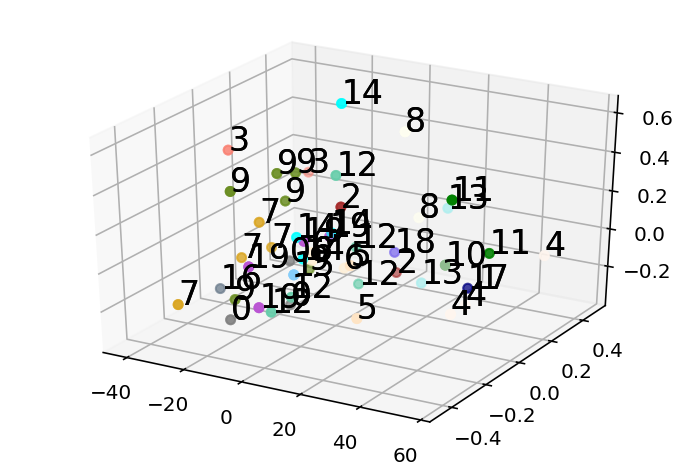

In [11]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
   
fig = plt.figure() 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 
   
list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 

plt.show()

### Cluster Analysis

In [12]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dfs)
y_kmeans = kmeans.fit_predict(scaled)
y_kmeans

array([19,  9,  9,  5,  6,  7, 15,  2, 13, 11, 13,  9,  7,  0, 14, 11, 15,
       10,  4, 17,  2,  3, 13,  9,  4, 17, 15, 18,  3,  1,  0,  8,  1, 14,
       15, 15,  8,  6, 15, 14,  0, 15,  6, 16, 11,  2, 12,  7,  5,  7, 19,
        9,  9,  5,  6,  7, 15,  2, 13, 11, 13,  9,  7,  0, 14, 11, 15, 10,
        4, 17,  2,  3, 13,  9,  4, 17, 15, 18,  3,  1,  0,  8,  1, 14, 15,
       15,  8,  6, 15, 14,  0, 15,  6, 16, 11,  2, 12,  7,  5,  7])

In [13]:
dfs['cluster'] = y_kmeans
dfs['artist'] = temp.artist.tolist()
dfs['title'] = temp.song.tolist()
dfs.head()

,danceability,energy,speechiness,acousticness,valence,tempo,cluster,artist,title
id,,,,,,,,,
2QXB9GugNcZqXrDXYowISU,0.596,0.933,0.0771,0.1640,0.910,155.008,19,Rico Nasty,Time Flies
7fPuWrlpwDcHm5aHCH5D9t,0.785,0.721,0.0506,0.0149,0.894,121.962,9,SAINt JHN,Roses - Imanbek Remix
0y60itmpH0aPKsFiGxmtnh,0.764,0.705,0.0278,0.0371,0.672,101.003,9,WILLOW,Wait a Minute!
6U0FIYXCQ3TGrk4tFpLrEA,0.453,0.538,0.0638,0.4490,0.516,122.973,5,BROCKHAMPTON,SUGAR
3HBj2yLbgrJv1VWbMpU5sc,0.481,0.736,0.3460,0.0569,0.436,176.271,6,SoySauce,Broken Record (feat. Joni Fatora)


In [14]:
#visualize the feature 
dfs.loc[dfs['cluster'] == 15]

,danceability,energy,speechiness,acousticness,valence,tempo,cluster,artist,title
id,,,,,,,,,
1Lim1Py7xBgbAkAys3AGAG,0.723,0.809,0.0625,0.00346,0.2740,98.007,15,Major Lazer,Lean On
62N2JSA0jHmSH7Va9t7hIf,0.735,0.686,0.0366,0.00108,0.0656,121.011,15,Tove Lo,Habits (Stay High) - Hippie Sabotage Remix
1LeItUMezKA1HdCHxYICed,0.749,0.745,0.0479,0.00410,0.3470,115.048,15,ODESZA,Say My Name (feat. Zyra)
4PhsKqMdgMEUSstTDAmMpg,0.572,0.631,0.0476,0.22200,0.0713,134.078,15,The Weeknd,Often
6FzjJPwf5JzzFOei7h6Qrp,0.592,0.911,0.0659,0.00608,0.2110,103.517,15,Armin van Buuren,Great Spirit
6kQzmbSkHGexuwD9D3zNom,0.656,0.799,0.0405,0.00136,0.2470,115.936,15,ZAYN,"Dusk Till Dawn (feat. Sia) - John ""J-C"" Carr Mix"
1LQiF6aZfnNgxerxWJRbxw,0.603,0.827,0.0714,0.04530,0.3110,144.992,15,Hermitude,HyperParadise - Flume Remix
1Lim1Py7xBgbAkAys3AGAG,0.723,0.809,0.0625,0.00346,0.2740,98.007,15,Major Lazer,Lean On
62N2JSA0jHmSH7Va9t7hIf,0.735,0.686,0.0366,0.00108,0.0656,121.011,15,Tove Lo,Habits (Stay High) - Hippie Sabotage Remix


In [15]:
#6 k-means assumed to cluster genres, but we are using k=20
dfs.groupby(['cluster']).count()

,danceability,energy,speechiness,acousticness,valence,tempo,artist,title
cluster,,,,,,,,
0,6,6,6,6,6,6,6,6
1,4,4,4,4,4,4,4,4
2,6,6,6,6,6,6,6,6
3,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4
5,4,4,4,4,4,4,4,4
6,6,6,6,6,6,6,6,6
7,8,8,8,8,8,8,8,8
8,4,4,4,4,4,4,4,4


In [16]:
#create list of lists of song ids to put into recommendation function
i=0
list_of_recs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
while i<20:
    list_of_recs[i] = dfs.loc[dfs['cluster'] == i].index.to_list()
    i+=1
len(list_of_recs)

20

In [17]:
j = 0
while j<20:
    if len(list_of_recs[j]) < 5:
        
    

SyntaxError: unexpected EOF while parsing (<ipython-input-17-f6e13a363f0f>, line 5)

-------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

In [23]:
#from sklearn_extra.cluster import KMedoids

#kmedoids = KMedoids(n_clusters=20, random_state=0)
#kmedoids.fit(dfs)
#kmedoids.cluster_centers_
#these are the coordinates of the 5 cluster medoids but not sure how to identify which 5 songs are represented by these points

## Create the New Playlist
Next, we are going to create a new playlist and add to it all the tracks we ended up selecting:

In [ ]:
# Authorization flow

scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [ ]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [ ]:
create_playlist(sp, username, 'Pandas Party', 'A pure party playlist created by DJ Pandas!')

In [ ]:
# Find the new playlist's id
fetch_playlists(sp,username)

In [122]:
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 100])
        index += 100

In [123]:
list_track = df_party_exp_III.index

In [126]:
enrich_playlist(sp, username, '779Uv1K6LcYiiWxblSDjx7', list_track)

SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/users/11153510588/playlists/779Uv1K6LcYiiWxblSDjx7/tracks:
 Insufficient client scope